<a href="https://colab.research.google.com/github/danhorsley/DS-Unit-2-Sprint-2-Regression/blob/master/assignment_2_try_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
import pandas as pd
import numpy as np
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')
#dropping ids and mapping quality to an order of numbers
df=df.drop(['Id','MasVnrArea'],axis=1)
qual_dict={'NA':-1,'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4}
cat_quals=['ExterQual','ExterCond','KitchenQual','BsmtQual','BsmtCond','GarageQual','GarageCond','HeatingQC','FireplaceQu']#,'Fence']
for col in cat_quals:
  df[col]=df[col].map(qual_dict)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [166]:
df['MasVnrArea'].value_counts()

Series([], Name: MasVnrArea, dtype: int64)

In [0]:
#new build category and renovated category using YrSold, 'YearBuilt', 'YearRemodAdd
df['new_build']=np.where((df['YrSold']==df['YearBuilt']),1,0)
df['reno']=np.where((df['YearBuilt']!=df['YearRemodAdd']),1,0)
df['SF_per_room']=(df['1stFlrSF']+df['2ndFlrSF'])/df['TotRmsAbvGrd']
df['bth_per_SF']=(df['BsmtFullBath']+0.5*df['BsmtHalfBath']+ df['FullBath']+0.5*df['HalfBath'])/df['GrLivArea']
df['rel_lot_size']=df['LotArea']/df['GrLivArea'] 
df['fireplace_per_SF']=df['Fireplaces']/df['GrLivArea']
#make a dictionary of urban density and use it to make new column
density_dict=df.groupby('Neighborhood', as_index=False)['LotArea'].mean().set_index('Neighborhood').to_dict()['LotArea']
df['urban_density']=df['Neighborhood'].map(density_dict)
#same for area age
age_dict=df.groupby('Neighborhood', as_index=False)['YearBuilt'].mean().set_index('Neighborhood').to_dict()['YearBuilt']
df['area_age']=df['Neighborhood'].map(age_dict)
#now an area quality dictionary
area_qual_dict=df.groupby('Neighborhood', as_index=False)['OverallQual'].mean().set_index('Neighborhood').to_dict()['OverallQual']
df['area_qual']=df['Neighborhood'].map(area_qual_dict)
#noise polution list and check
noise_high_list=['Artery','RRAn','RRAe']
df['noisy']=np.where(df['Condition1'].isin(noise_high_list),1,0)

#log of sale price to de-skew
df['ln_price'] = np.log(df['SalePrice'])



In [0]:
#map rest of categorical features to numbers
df_coded=df.copy()
for col in df_coded.columns:
  if df_coded[col].dtype=='O':
    df_coded[col] = pd.Categorical(df_coded[col])
    df_coded[col] = df_coded[col].cat.codes
    
df_coded['LotFrontage']=df_coded['LotFrontage'].fillna(df_coded['LotFrontage'].mean())
df_coded['FireplaceQu']=df_coded['FireplaceQu'].fillna(0)
df_coded['GarageQual']=df_coded['GarageQual'].fillna(0)
df_coded['GarageCond']=df_coded['GarageCond'].fillna(0)
df_coded['BsmtQual']=df_coded['BsmtQual'].fillna(0)
df_coded['BsmtCond']=df_coded['BsmtCond'].fillna(0)
df_coded['GarageYrBlt']=np.where(df_coded['GarageYrBlt'].isna()==True,df_coded['YearBuilt'],df_coded['GarageYrBlt'])



In [248]:
#somewhat amazingly three engineered features have a very high correlation, with area_qual being the second highest out of everything
corr_list=[]
for col in df_coded.columns:
  aaa=(col,df_coded['ln_price'].corr(df_coded[col]))
  corr_list.append(aaa)
  
corr_list.sort(key=lambda x: x[1])
corr_list[-12:-2] #excluding sale price and ln price

[('1stFlrSF', 0.5969810450343741),
 ('TotalBsmtSF', 0.6121339753697866),
 ('BsmtQual', 0.6477178203062742),
 ('GarageArea', 0.6508875559020073),
 ('KitchenQual', 0.6678930256021669),
 ('ExterQual', 0.6788398348643079),
 ('GarageCars', 0.6806248074360477),
 ('GrLivArea', 0.7009266525441299),
 ('area_qual', 0.7201461036753571),
 ('OverallQual', 0.8171844179216825)]

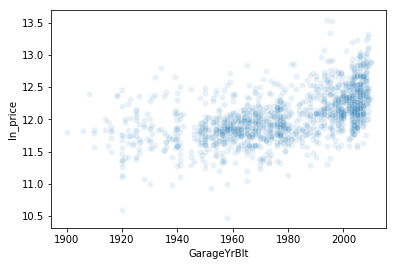

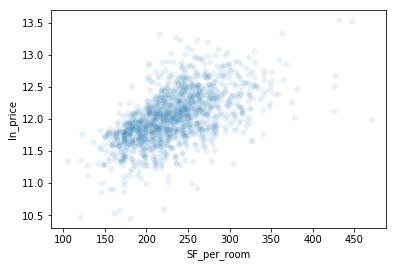

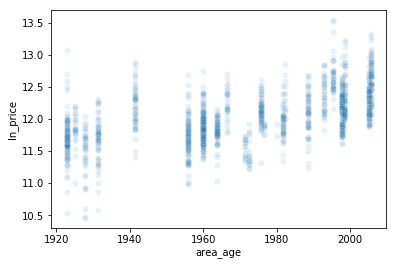

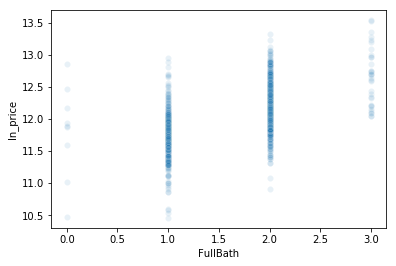

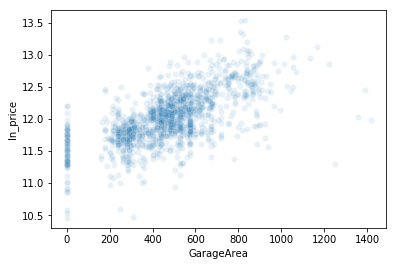

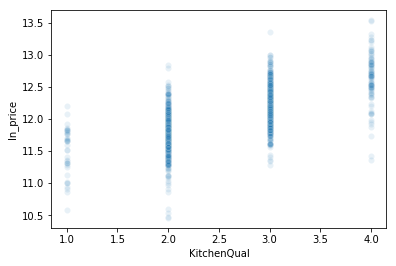

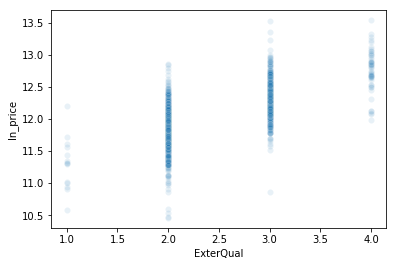

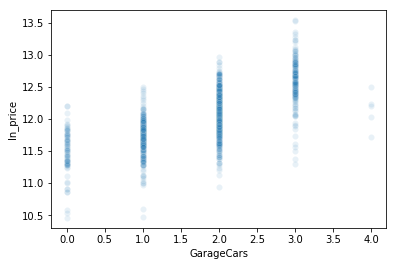

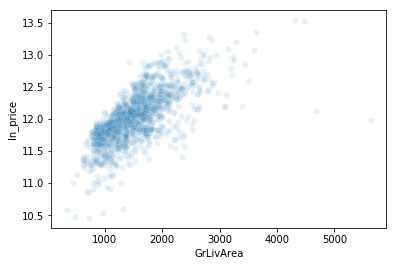

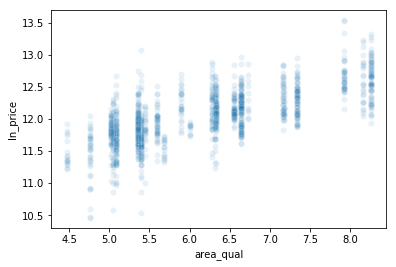

In [102]:
import seaborn as sns
lin_feats=[corr_list[-12:-2][i][0] for i in range(0,len(corr_list[-12:-2]))]
for feat in lin_feats:
  sns.scatterplot(x=feat, y='ln_price', data=df_coded, alpha=0.1)
  #plt.scatter(df_coded[feat],df_coded['ln_price'])
  #plt.title=(feat)
  plt.show();

In [249]:
#additional features
additional_features=[corr_list[-22:-12][i][0] for i in range(0,len(corr_list[-22:-12]))]
additional_features

['HeatingQC',
 'Fireplaces',
 'TotRmsAbvGrd',
 'FireplaceQu',
 'YearRemodAdd',
 'SF_per_room',
 'GarageYrBlt',
 'area_age',
 'YearBuilt',
 'FullBath']

In [250]:
even_more_feats=[corr_list[-32:-22][i][0] for i in range(0,len(corr_list[-22:-12]))]
even_more_feats

['HalfBath',
 '2ndFlrSF',
 'OpenPorchSF',
 'WoodDeckSF',
 'LotFrontage',
 'CentralAir',
 'GarageCond',
 'GarageQual',
 'BsmtFinSF1',
 'Foundation']

In [258]:
(lin_feats+additional_features)

['GarageYrBlt',
 'SF_per_room',
 'area_age',
 'FullBath',
 'GarageArea',
 'KitchenQual',
 'ExterQual',
 'GarageCars',
 'GrLivArea',
 'area_qual',
 'HeatingQC',
 'Fireplaces',
 'TotRmsAbvGrd',
 'FireplaceQu',
 'YearRemodAdd',
 'SF_per_room',
 'GarageYrBlt',
 'area_age',
 'YearBuilt',
 'FullBath']

In [259]:
#add polynomial features
poly_feats=[]
for ft in (lin_feats+additional_features):
  name = f'{ft} **2'
  df_coded[name]=df_coded[ft]**2
  poly_feats.append(name)
  
#df_coded['grg_yr_blt_sqrd']=df_coded['GarageYrBlt']**2
#df_coded['OQ_sqrd']=df_coded['OverallQual']**2
#poly_feats=['grg_yr_blt_sqrd','OQ_sqrd','OverallQual']

all_feats=lin_feats+poly_feats+additional_features+even_more_feats+pca_feats
all_feats

['GarageYrBlt',
 'SF_per_room',
 'area_age',
 'FullBath',
 'GarageArea',
 'KitchenQual',
 'ExterQual',
 'GarageCars',
 'GrLivArea',
 'area_qual',
 'GarageYrBlt **2',
 'SF_per_room **2',
 'area_age **2',
 'FullBath **2',
 'GarageArea **2',
 'KitchenQual **2',
 'ExterQual **2',
 'GarageCars **2',
 'GrLivArea **2',
 'area_qual **2',
 'HeatingQC **2',
 'Fireplaces **2',
 'TotRmsAbvGrd **2',
 'FireplaceQu **2',
 'YearRemodAdd **2',
 'SF_per_room **2',
 'GarageYrBlt **2',
 'area_age **2',
 'YearBuilt **2',
 'FullBath **2',
 'HeatingQC',
 'Fireplaces',
 'TotRmsAbvGrd',
 'FireplaceQu',
 'YearRemodAdd',
 'SF_per_room',
 'GarageYrBlt',
 'area_age',
 'YearBuilt',
 'FullBath',
 'HalfBath',
 '2ndFlrSF',
 'OpenPorchSF',
 'WoodDeckSF',
 'LotFrontage',
 'CentralAir',
 'GarageCond',
 'GarageQual',
 'BsmtFinSF1',
 'Foundation',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'h',
 'i',
 'j',
 'k']

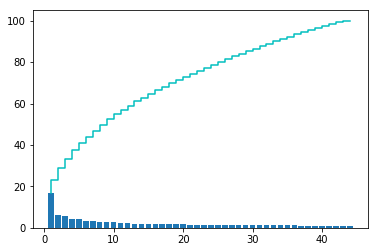

In [200]:
from sklearn.decomposition import PCA
Z=df_coded[every_feat].copy()
for col in Z.columns:
  Z[col]=(Z[col]-Z[col].mean())/Z[col].std()
n = len(Z.columns)
pca_scree = PCA(int(n/2))
pca_scree.fit(Z)
pca_scree.explained_variance_
pca_scree_df = pd.DataFrame(pca_scree.explained_variance_)
pca_scree_df.columns = ['Explained Variance']
pca_scree_df['Explained Variance'] = 100*pca_scree_df['Explained Variance']/pca_scree_df['Explained Variance'].sum()
pca_scree_df['Explained Variance Ratio Cumulative'] = pca_scree_df['Explained Variance'].cumsum()
pca_scree_df['Number of Principal Components'] = pca_scree_df.index+1
plt.bar(pca_scree_df['Number of Principal Components'],pca_scree_df['Explained Variance'])
plt.step(pca_scree_df['Number of Principal Components'],pca_scree_df['Explained Variance Ratio Cumulative'],c='c');

In [201]:
#10 principal components gets you 50% of explained variance
pca_scree_df['Explained Variance Ratio Cumulative'].head(10)

0    16.749066
1    23.131539
2    29.057138
3    33.314946
4    37.428201
5    40.884369
6    44.007910
7    46.928607
8    49.754408
9    52.417362
Name: Explained Variance Ratio Cumulative, dtype: float64

In [0]:
pca = PCA(10)
pca.fit(Z)
ZT = pca.transform(Z)
Z_pca=pd.DataFrame(ZT)
Z_pca.columns=['a','b','c','d','e','f','h','i','j','k']
for col in Z_pca.columns:
  df_coded[col]=Z_pca[col]

In [254]:
df_coded.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,a,b,c,d,e,f,h,i,j,k
0,60,3,65.0,8450,1,-1,3,3,0,4,...,2.299640,-2.265711,-1.371312,0.227010,1.248862,-0.259725,1.646920,1.482322,0.672088,-0.555835
1,20,3,80.0,9600,1,-1,3,3,0,2,...,0.700533,-0.269658,2.545133,-0.387469,0.117455,-0.624880,-0.100085,0.056688,-0.745639,-0.641467
2,60,3,68.0,11250,1,-1,0,3,0,4,...,3.207533,-0.861195,-0.742066,0.152516,1.002007,-1.135306,1.418139,-0.556579,0.551444,-0.994636
3,70,3,60.0,9550,1,-1,0,3,0,0,...,-0.568226,2.143304,-0.185677,-2.428957,0.734170,-1.264822,-0.000616,-0.456906,1.216684,0.554948
4,60,3,84.0,14260,1,-1,0,3,0,2,...,5.274276,0.628974,-0.562027,0.659516,1.548601,0.572307,1.772592,0.337073,0.193339,-0.786251


In [217]:
pca_feats=list(Z_pca.columns)
pca_feats

['a', 'b', 'c', 'd', 'e', 'f', 'h', 'i', 'j', 'k']

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def scorer(feats):
  from statistics import mean 
  mean_rmse=[]
  mean_r2=[]
  X=df_coded[feats]
  y=df_coded[['ln_price']]
  for i in range(1,25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=i)

    model=LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)
    mean_rmse.append(rmse)
    mean_r2.append(r2)
    
  return mean(mean_rmse),mean(mean_r2)

In [260]:
#this is lower once i move aroudn random seed
scorer(all_feats)

(0.14423641723014205, 0.8657217962913674)

In [261]:
#so i get even higher for every feature
scorer(every_feat)

(0.13790345614392932, 0.8762312559750969)

In [265]:
#this is using brute force.....
#featstoshuff=all_feats
featstoshuff=every_feat
import random
for i in range(0,1000):
  random.shuffle(featstoshuff)
  temp=featstoshuff[0:60]
  bbb=scorer(temp)
  answer=(bbb[0],bbb[1],temp)
  if bbb[1]>0.878:
    print(answer)

(0.136629632417519, 0.8795610481733365, ['LandContour', 'LotFrontage', 'HeatingQC', 'rel_lot_size', 'MSZoning', 'bth_per_SF', 'Condition1', 'BsmtFullBath', 'Exterior2nd', 'BsmtQual', 'ScreenPorch', 'BsmtFinType2', 'OpenPorchSF', '1stFlrSF', 'KitchenQual', 'FullBath', 'GarageCars', 'noisy', 'HouseStyle', 'GarageArea', 'area_qual', 'GrLivArea', 'WoodDeckSF', 'HalfBath', 'RoofStyle', 'reno', 'LandSlope', 'LotConfig', 'ExterQual', 'EnclosedPorch', 'BsmtFinType1', '2ndFlrSF', 'Functional', 'YearRemodAdd', 'BsmtHalfBath', 'fireplace_per_SF', 'MSSubClass', 'OverallQual', 'KitchenAbvGr', 'GarageFinish', 'GarageQual', 'SF_per_room', 'Exterior1st', '3SsnPorch', 'urban_density', 'MiscFeature', 'RoofMatl', 'MoSold', 'BsmtExposure', 'FireplaceQu', 'PoolQC', 'SaleType', 'ExterCond', 'BsmtCond', 'OverallCond', 'Utilities', 'TotRmsAbvGrd', 'PoolArea', 'SaleCondition', 'GarageCond'])
(0.13750730415319143, 0.8781991832024199, ['YearBuilt', 'ExterCond', 'MasVnrType', 'Fireplaces', '2ndFlrSF', 'GarageYrBl

In [0]:
seed=46
best_combo=(0.1378905458271945, 0.8778489718699903, ['PavedDrive', 'area_qual', 'ExterQual', 'OverallQual', 'KitchenQual', 'FullBath', 'KitchenAbvGr', 'SF_per_room', 'new_build', 'Functional', 'HeatingQC', 'OverallCond', 'SaleCondition', 'ScreenPorch', 'HalfBath', 'area_age', 'Neighborhood', 'RoofMatl', 'LotArea', 'LotConfig', 'BsmtFinSF2', '1stFlrSF', 'MoSold', 'MSZoning', 'EnclosedPorch', 'SaleType', 'Foundation', 'CentralAir', 'Electrical', 'MSSubClass', 'GarageCond', 'Exterior1st', '2ndFlrSF', 'LotShape', 'Heating', 'WoodDeckSF', 'BsmtFullBath', 'Fireplaces', 'OpenPorchSF', 'GarageType', 'rel_lot_size', 'MiscVal', 'Condition2', 'BsmtHalfBath', 'TotRmsAbvGrd', 'GarageFinish', 'bth_per_SF', 'reno', 'BsmtExposure', 'GarageCars'])
best_combo2=(0.136629632417519, 0.8795610481733365, ['LandContour', 'LotFrontage', 'HeatingQC', 'rel_lot_size', 'MSZoning', 'bth_per_SF', 'Condition1', 'BsmtFullBath', 'Exterior2nd', 'BsmtQual', 'ScreenPorch', 'BsmtFinType2', 'OpenPorchSF', '1stFlrSF', 'KitchenQual', 'FullBath', 'GarageCars', 'noisy', 'HouseStyle', 'GarageArea', 'area_qual', 'GrLivArea', 'WoodDeckSF', 'HalfBath', 'RoofStyle', 'reno', 'LandSlope', 'LotConfig', 'ExterQual', 'EnclosedPorch', 'BsmtFinType1', '2ndFlrSF', 'Functional', 'YearRemodAdd', 'BsmtHalfBath', 'fireplace_per_SF', 'MSSubClass', 'OverallQual', 'KitchenAbvGr', 'GarageFinish', 'GarageQual', 'SF_per_room', 'Exterior1st', '3SsnPorch', 'urban_density', 'MiscFeature', 'RoofMatl', 'MoSold', 'BsmtExposure', 'FireplaceQu', 'PoolQC', 'SaleType', 'ExterCond', 'BsmtCond', 'OverallCond', 'Utilities', 'TotRmsAbvGrd', 'PoolArea', 'SaleCondition', 'GarageCond'])
best_combo3=(0.13635617233675906, 0.8800861437889757, ['Heating', 'bth_per_SF', 'area_qual', 'ExterCond', 'ScreenPorch', 'SF_per_room', 'OverallQual', 'urban_density', 'GarageFinish', 'KitchenQual', 'OverallCond', 'Fence', 'GarageYrBlt', 'PavedDrive', 'noisy', 'ExterQual', 'BsmtFullBath', 'BsmtFinSF1', 'Electrical', 'BsmtCond', 'BldgType', 'YrSold', 'BsmtQual', 'Utilities', 'GarageType', 'Fireplaces', 'WoodDeckSF', 'Street', 'LowQualFinSF', 'BsmtFinType1', 'TotRmsAbvGrd', 'Exterior2nd', '1stFlrSF', 'LotConfig', 'MiscVal', 'GrLivArea', 'BedroomAbvGr', 'LotArea', 'HouseStyle', 'Condition1', '2ndFlrSF', 'MasVnrType', 'YearBuilt', 'GarageCond', 'GarageQual', 'SaleType', 'RoofStyle', 'GarageCars', 'Exterior1st', 'area_age', 'MiscFeature', 'OpenPorchSF', 'Condition2', 'MSZoning', 'SaleCondition', 'MSSubClass', 'Foundation', 'rel_lot_size', 'Neighborhood', 'BsmtExposure'])

In [277]:
#this is best i can get....
combo_feats=best_combo3[2]
X=df_coded[combo_feats]
y=df_coded[['ln_price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=seed)

model=LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

rmse,r2

(0.1200781718692583, 0.9085162373332754)

In [0]:
every_feat=['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition',
       'new_build', 'reno', 'SF_per_room', 'bth_per_SF', 'rel_lot_size',
       'fireplace_per_SF', 'urban_density', 'area_age', 'area_qual', 'noisy',
     #  'a', 'b', 'c', 'd', 'e', 'f', 'h', 'i', 'j', 'k'
           ]

In [278]:
len(every_feat)

88